# 🛍️ SmartCart Starter Notebook
This notebook will guide you through your group project on collaborative filtering and association rule mining for an e-commerce recommender system.

## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [2]:
# Load data
import pandas as pd

user_data = pd.read_csv('ecommerce_user_data.csv')
product_data = pd.read_csv('product_details.csv')

user_data.head()


,UserID,ProductID,Rating,Timestamp,Category
0,U000,P0009,5,2024-09-08,Books
1,U000,P0020,1,2024-09-02,Home
2,U000,P0012,4,2024-10-18,Books
3,U000,P0013,1,2024-09-18,Clothing
4,U000,P0070,4,2024-09-16,Toys


In [3]:
product_data.head()


,ProductID,ProductName,Category
0,P0000,Toys Item 0,Clothing
1,P0001,Clothing Item 1,Electronics
2,P0002,Books Item 2,Electronics
3,P0003,Clothing Item 3,Electronics
4,P0004,Clothing Item 4,Electronics


In [4]:
user_data.isna().any()


UserID       False
ProductID    False
Rating       False
Timestamp    False
Category     False
dtype: bool

In [5]:
product_data.isna().any()


ProductID      False
ProductName    False
Category       False
dtype: bool

- Regarding both the user category purchase table and the details table, there are no values to clean or replace as there are no na values.

In [6]:
rating_values = user_data.Rating.unique()
rating_values.sort()
rating_values


array([1, 2, 3, 4, 5])

In [7]:
user_data.Category.unique()


array(['Books', 'Home', 'Clothing', 'Toys', 'Electronics', 'Beauty'],
      dtype=object)

- From the data, it seems that the application should put out recommendations for user purchases and put out similar similar products based on user reviews
    - This would be a **user-based collaborative filtering** problem basing off ratings and categories.

In [8]:
# Create user-item matrix
full_user_data = pd.merge(user_data, product_data, on='ProductID', how='inner')
user_item_matrix = full_user_data.pivot_table(index='UserID', columns='ProductName', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_item_matrix_filled.head()


ProductName,Beauty Item 12,Beauty Item 16,Beauty Item 17,Beauty Item 24,Beauty Item 34,Beauty Item 35,Beauty Item 36,Beauty Item 50,Beauty Item 63,Beauty Item 69,...,Toys Item 60,Toys Item 65,Toys Item 67,Toys Item 73,Toys Item 78,Toys Item 82,Toys Item 85,Toys Item 94,Toys Item 95,Toys Item 96
UserID,,,,,,,,,,,,,,,,,,,,,
U000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
U002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
U003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
U004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Replcae 0 wih median

- From the user-item matrix, we can see that the matrix is sparse, which means that most of the values are missing. This is because not all users have rated all products. 
    - As a result, the sparse matrix can cause the recommendation system to be susceptible to the **Cold-Start Probblem**, whereby a lack of data will make similarity measures imprecise and inaccurate. 
    - To alleviate the problem, **cosine similarity** can be used. It minimizes the issue by comparing direction and not magnitude when representing the user data in vector spaces.

In [9]:
# Aggregate user behavior by category
user_category_agg = user_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
user_category_agg.head()


,UserID,Category,TotalInteractions,AverageRating
0,U000,Books,6,3.666667
1,U000,Clothing,3,1.666667
2,U000,Electronics,3,3.666667
3,U000,Home,2,1.000000
4,U000,Toys,6,3.500000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

In [10]:
# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_filled)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)
similarity_df.head()


UserID,U000,U001,U002,U003,U004,U005,U006,U007,U008,U009,...,U040,U041,U042,U043,U044,U045,U046,U047,U048,U049
UserID,,,,,,,,,,,,,,,,,,,,,
U000,1.000000,0.063071,0.195522,0.023466,0.065412,0.161251,0.160096,0.092083,0.238263,0.274844,...,0.241693,0.129483,0.156790,0.132200,0.161478,0.100346,0.126917,0.150727,0.000000,0.104294
U001,0.063071,1.000000,0.190861,0.000000,0.111332,0.009540,0.000000,0.172286,0.167460,0.017593,...,0.121540,0.024075,0.097953,0.007821,0.000000,0.000000,0.193670,0.247805,0.000000,0.000000
U002,0.195522,0.190861,1.000000,0.065094,0.111662,0.050830,0.027756,0.055877,0.000000,0.181229,...,0.144756,0.000000,0.217465,0.000000,0.055992,0.034794,0.194243,0.110030,0.177165,0.000000
U003,0.023466,0.000000,0.065094,1.000000,0.035737,0.104116,0.026650,0.000000,0.025384,0.288009,...,0.243836,0.000000,0.000000,0.074688,0.197121,0.000000,0.054396,0.126773,0.374228,0.250000
U004,0.065412,0.111332,0.111662,0.035737,1.000000,0.159064,0.057144,0.026294,0.195942,0.247023,...,0.062741,0.116202,0.078797,0.048044,0.103747,0.133716,0.124969,0.217464,0.255318,0.172729


In [11]:
# Create recommendation function
# Find most similar user, recommend products they rated highly that target user hasn’t rated
def recommend_products(_similarity_matrix: pd.DataFrame, _userID: str, _user_ratings_matrix:  pd.DataFrame, _k: int) -> pd.Series:
    sorted_user_similarity = _similarity_matrix[_userID].sort_values(ascending=False).iloc[1:]
    most_significant_users = sorted_user_similarity.loc[sorted_user_similarity >= .1]
    similar_user_ratings = _user_ratings_matrix.loc[most_significant_users.index]

    unrated_items = _user_ratings_matrix.loc[_userID][_user_ratings_matrix.loc[_userID] == 0].index
    recommendations = (most_significant_users * similar_user_ratings.transpose()).transpose().sum() / most_significant_users.sum()
    
    return recommendations.loc[unrated_items].sort_values(ascending=False).head(_k)


In [12]:
k = 5

recommendations_dictionary = {}
for user in user_item_matrix_filled.index:
    recommendations_dictionary[user] = recommend_products(similarity_df, user, user_item_matrix_filled, k)


In [13]:
for user, recommendations in recommendations_dictionary.items():
    print(f"User {user} recommendations:")
    print(recommendations)
    print()


User U000 recommendations:
ProductName
Electronics Item 64    1.000406
Home Item 77           0.940371
Clothing Item 88       0.900053
Home Item 51           0.864153
Beauty Item 83         0.836516
dtype: float64

User U001 recommendations:
ProductName
Beauty Item 70         1.268436
Clothing Item 88       1.140255
Electronics Item 64    1.106582
Toys Item 39           0.956282
Beauty Item 71         0.860334
dtype: float64

User U002 recommendations:
ProductName
Beauty Item 70     1.472271
Home Item 77       0.904701
Books Item 30      0.904084
Clothing Item 3    0.863313
Toys Item 33       0.855234
dtype: float64

User U003 recommendations:
ProductName
Toys Item 60      1.073288
Beauty Item 70    0.992757
Beauty Item 17    0.883839
Books Item 43     0.868666
Books Item 30     0.833864
dtype: float64

User U004 recommendations:
ProductName
Beauty Item 70         1.568909
Home Item 51           1.046398
Toys Item 65           0.842291
Clothing Item 89       0.811721
Electronics Item 6

In [14]:
# Implement evaluation metrics like Precision@K and Coverage
# Example: compare recommended vs actual rated items
def precision_at_k(_recommended_products: pd.Index, _relevant_products: pd.Index, _k: int) -> float:
    return len(_recommended_products.intersection(_relevant_products)) / _k


def recall_at_k(_recommended_products: pd.Index, _relevant_products: pd.Index, _k: int) -> float:
    return len(_recommended_products.intersection(_relevant_products)) / len(_relevant_products)


def average_precision_at_k(_recommended_products: pd.Index, _relevant_products: pd.Index, _k: int) -> float:
    relevant_recommendations = _recommended_products.intersection(_relevant_products)
    precision_values = [precision_at_k(_recommended_products[:i], _relevant_products, i + 1) for i in range(_k) if _recommended_products[i] in relevant_recommendations]
    
    return sum(precision_values) / _k


In [15]:
actual_products = user_item_matrix_filled.loc[:].mean(axis=0)
relevant_products = actual_products[actual_products > 0.5].sort_values(ascending=False)

average_precision_dict = {}

for user in recommendations_dictionary.keys():
    recommended_products = recommendations_dictionary[user].index
    precision = precision_at_k(recommendations_dictionary[user].index, relevant_products.index, k)
    print(f"User {user} precision: {precision}")

    recall = recall_at_k(recommendations_dictionary[user].index, relevant_products.index, k)
    print(f"User {user} recall: {recall}")

    average_precision_dict[user] = average_precision_at_k(recommendations_dictionary[user].index, relevant_products.index, k)

    print()


User U000 precision: 0.8
User U000 recall: 0.16666666666666666

User U001 precision: 1.0
User U001 recall: 0.20833333333333334

User U002 precision: 0.6
User U002 recall: 0.125

User U003 precision: 0.8
User U003 recall: 0.16666666666666666

User U004 precision: 1.0
User U004 recall: 0.20833333333333334

User U005 precision: 0.4
User U005 recall: 0.08333333333333333

User U006 precision: 1.0
User U006 recall: 0.20833333333333334

User U007 precision: 1.0
User U007 recall: 0.20833333333333334

User U008 precision: 0.8
User U008 recall: 0.16666666666666666

User U009 precision: 0.8
User U009 recall: 0.16666666666666666

User U010 precision: 0.6
User U010 recall: 0.125

User U011 precision: 1.0
User U011 recall: 0.20833333333333334

User U012 precision: 0.8
User U012 recall: 0.16666666666666666

User U013 precision: 0.8
User U013 recall: 0.16666666666666666

User U014 precision: 0.8
User U014 recall: 0.16666666666666666

User U015 precision: 0.8
User U015 recall: 0.16666666666666666

User

In [16]:
mean_average_precision = sum(average_precision_dict.values()) / len(average_precision_dict)
print(f"Mean Average Precision: {mean_average_precision}")


Mean Average Precision: 0.34566666666666657


## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

In [ ]:
# Convert to transaction format
from mlxtend.preprocessing import TransactionEncoder
transactions = user_data.groupby('UserID')['ProductID'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)


In [ ]:
# Apply Apriori and generate rules
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_itemsets = frequent_itemsets.nlargest(10, 'support')

product_mapping = product_data.set_index('ProductID')['ProductName'].to_dict()

map_itemset = lambda itemset : ", ".join(product_mapping.get(pid, pid) for pid in itemset)
top_itemsets['itemsets'] = top_itemsets['itemsets'].apply(map_itemset)


plt.figure(figsize=(12, 7))
colors = sns.color_palette("viridis", len(top_itemsets))

bars = plt.barh(
    top_itemsets['itemsets'],
    top_itemsets['support'], 
    color=colors, 
    edgecolor='black'
)

plt.xlabel('Support', fontsize=14)
plt.ylabel('Frequent Itemsets', fontsize=14)
plt.title('Top 10 Frequent Itemsets by Support', fontsize=16, fontweight='bold')

plt.gca().invert_yaxis()
plt.show()


## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

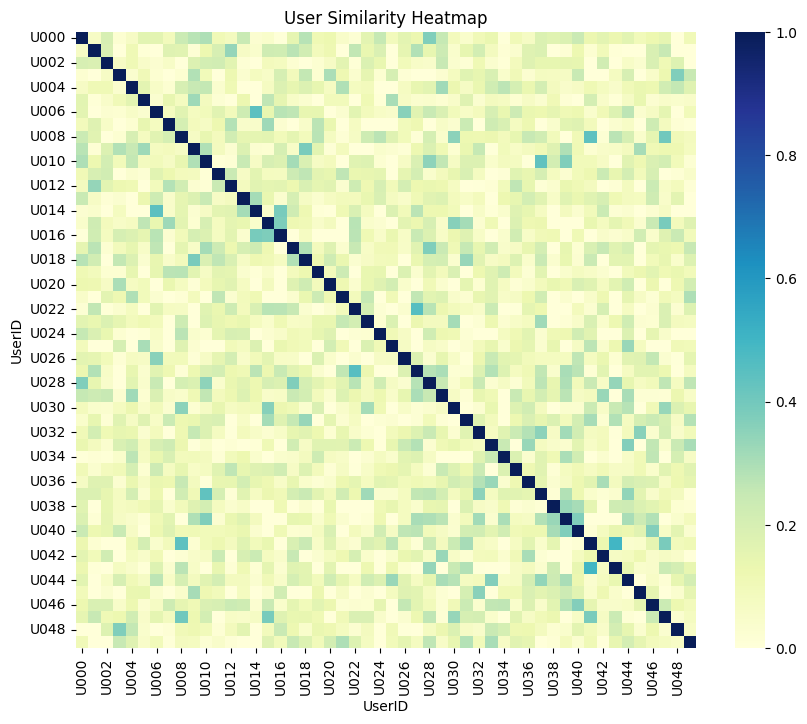

In [18]:
# Heatmap of user similarity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()


In [ ]:
# Frequent itemsets bar chart
frequent_itemsets.nlargest(10, 'support').plot(kind='bar', x='itemsets', y='support', legend=False)
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🧠 Part 5: Conceptual Questions
Answer the following questions in your report:
1. How does data sparsity affect performance?
2. What kinds of product bundles were discovered?
3. What improvements would you suggest for real-world deployment?